## In this notebook you can try different segmentation architecture on the task of cell-segmentation

In [1]:
#! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
#! unzip -q data.zip

In [2]:
%run dataset_loader.py
%run sift.py
%run UNET.py

In [3]:
import scipy as sp
import imageio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### First of all let's look at our dataset

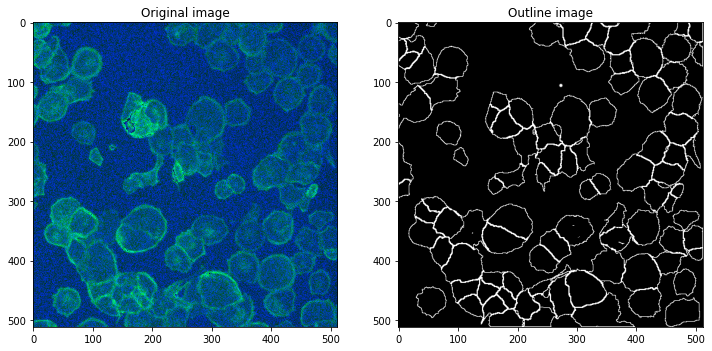

In [4]:
# Cells
f,ax = plt.subplots(1, 2, figsize=(12,6))

im = imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
mask = imageio.imread('BBBC018_v1_outlines/train/00735-cells.png')

ax[0].imshow(im)
ax[0].set_title('Original image')
ax[1].imshow(mask, 'gray')
ax[1].set_title('Outline image');

In [5]:
import os
import torch
import random

import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

IMG_PATH_TRAIN = "./BBBC018_v1_images-fixed/train/"
OUTLINE_PATH_TRAIN = "./BBBC018_v1_outlines/train/"

IMG_PATH_TEST = "./BBBC018_v1_images-fixed/val/"
OUTLINE_PATH_TEST = "./BBBC018_v1_outlines/val/"

### The main idea behind the dataset generating is multiple data augmentation, i.e. using different random seeds randomly apply some transformations

### To get the same random transformation for  ```original cell image``` and ```segmented cell image ``` I set the same seed to transform them in the same way.

In [6]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # Real Image are heavy
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

/home/boyarintsev.artem/catboost/venv/lib/python3.6/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


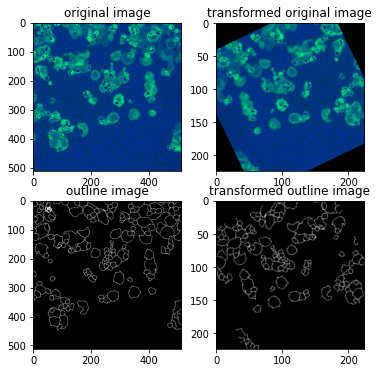

In [7]:
Train = get_dataset(transform_train, IMG_PATH_TRAIN, OUTLINE_PATH_TRAIN, show_examples_amount=1)

In [8]:
Test = get_dataset(transform_train, IMG_PATH_TEST, OUTLINE_PATH_TEST, show_examples_amount=1)

In [9]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
BATCH_SIZE=32
    

def train(model, train_dataset, test_dataset, num_epoch=32):
    model.double()
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        print(f'Epoch # {epoch}')
        model.eval()
        sift(model, train_dataset, test_dataset)
        model.train()
        for i, (batch) in enumerate(dataloader):
            images = batch[:,:-1,:,:]
            segm = batch[:,-1,:,:]
            
            gd.zero_grad()
            segmented_predicted = model(images.cuda())
            loss = (segm - segmented_predicted.cpu()).norm()
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
            images.cpu()  # Well, seems without cpu transfering gpu memory runs out
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [10]:
net = UNET().double().cuda()

In [11]:
# ensure that size is the right one
h=net(Train[:1,:3].cuda())
assert h.shape == (1,1,224,224)

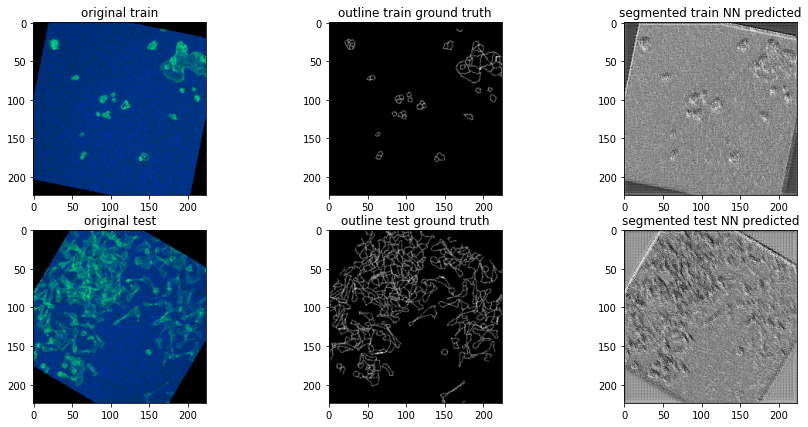

In [12]:
sift(net, Train, Test)

Epoch # 0


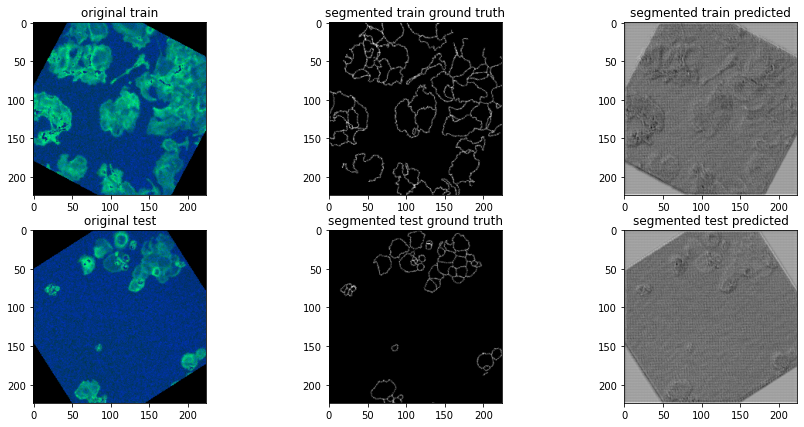

#1, Train loss: 2681.5080943
Epoch # 1


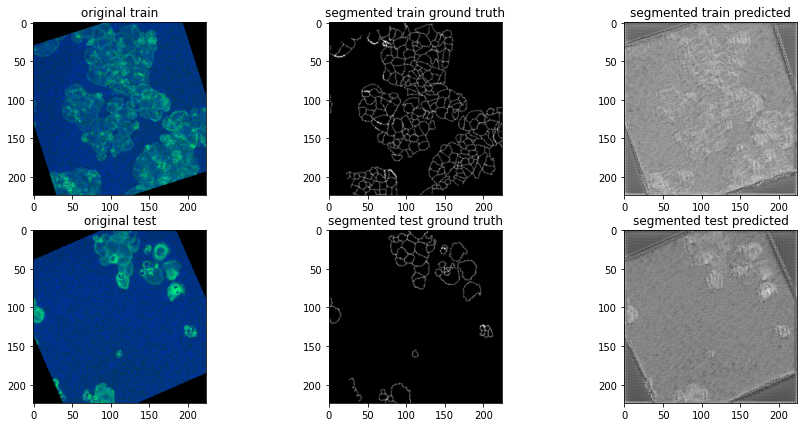

#2, Train loss: 1826.5261551
Epoch # 2


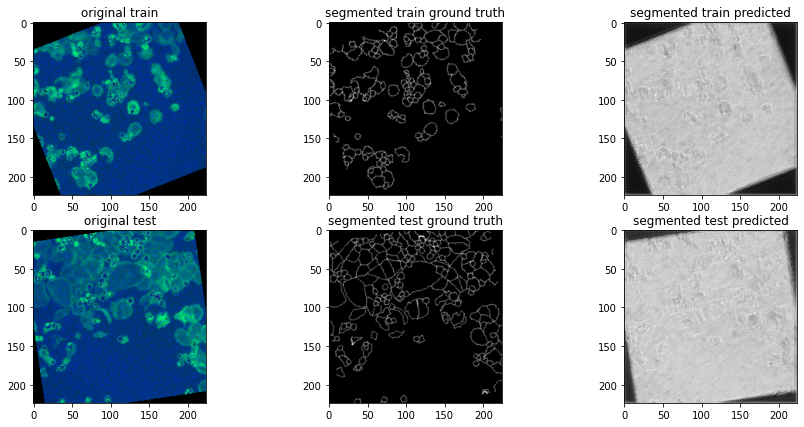

#3, Train loss: 1479.2266293
Epoch # 3


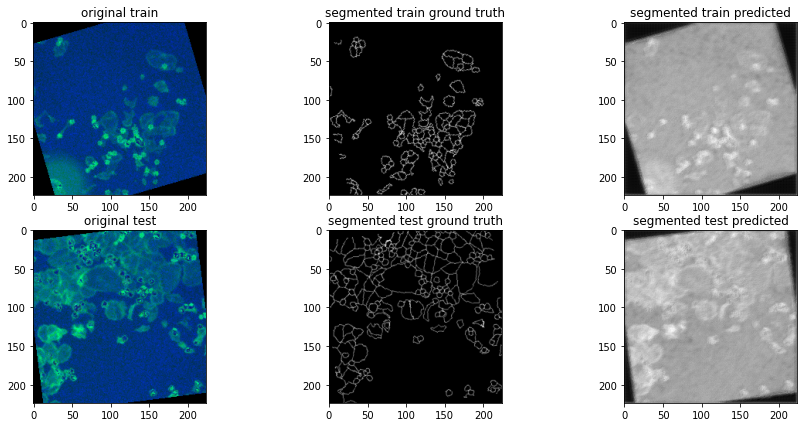

#4, Train loss: 1302.9921547
Epoch # 4


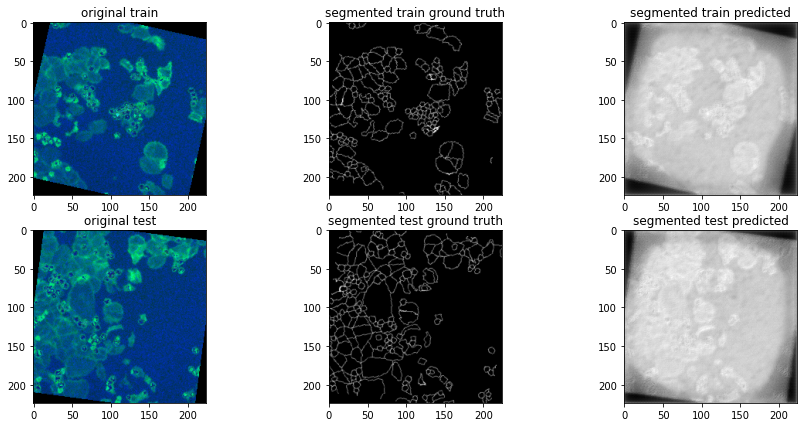

#5, Train loss: 1196.8452131
Epoch # 5


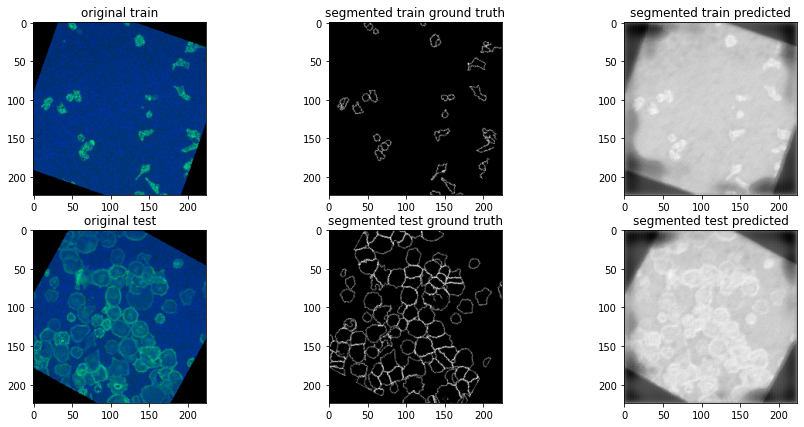

#6, Train loss: 1125.9675599
Epoch # 6


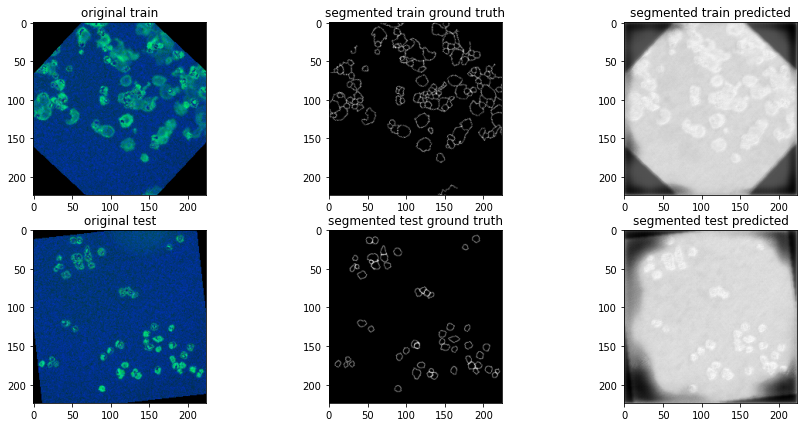

#7, Train loss: 1075.2763758
Epoch # 7


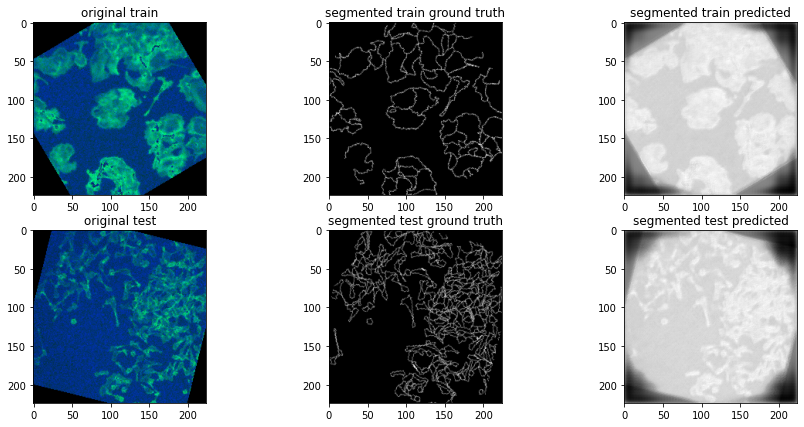

#8, Train loss: 1037.2448537
Epoch # 8


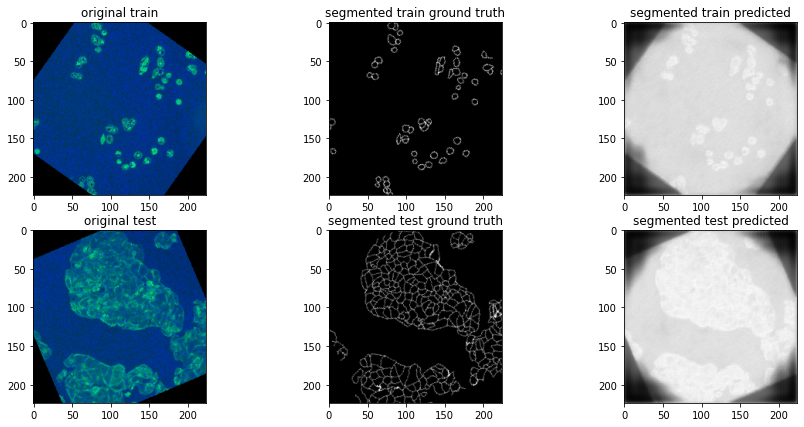

#9, Train loss: 1007.6827618
Epoch # 9


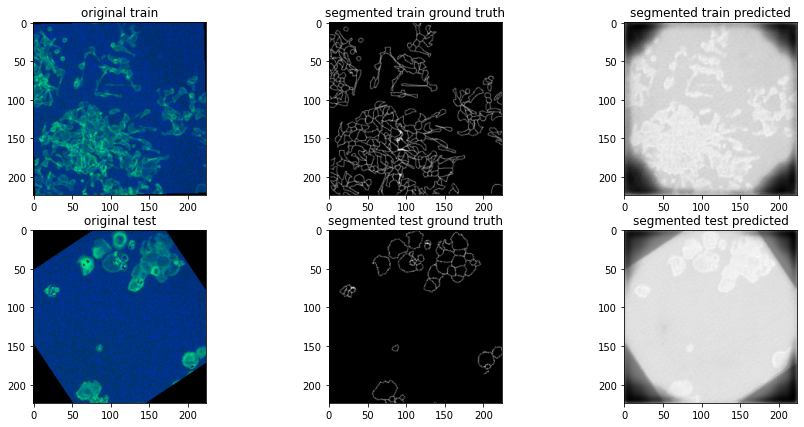

#10, Train loss: 984.0158562


In [13]:
train(net, Train, Test, num_epoch=32)
torch.save(net.state_dict(), './UNET_weights.save')

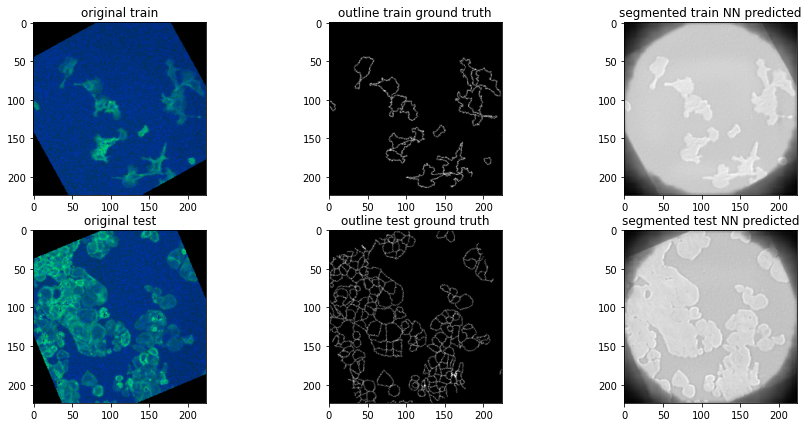

In [14]:
sift(net,Train, Test)